 A multiple linear regression (MLR) model for the prediction of demand for shared bikes.

#### Problem statement :

A US bike-sharing provider **BoomBikes** has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic.

Hence BoomBikes has decided to come up with a mindful business plan & understand the demand for shared bikes among the people, after the ongoing quarantine situation ends across the nation.
The company has contacted a consulting firm and wants to understand the factors affecting the demand for these shared bikes in the American market. They want to know: 
1. Which variables are significant in predicting the demand for shared bikes.
2. How well those variables describe the bike demands

    
Based on various meteorological surveys and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors. 

#### Business Goal:

- As the consulting firm, you need to model the demand for shared bikes with the available independent variables.
- It will be used by the management to understand how exactly the demands vary with different features. 
- They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations.
- Further, the model will be a good way for management to understand the demand dynamics of a new market. 

### The Solutioning invoves:

Data Preparation

- Read,understand the data
- Visualize the data and check for patterns(EDA - univariate, bi-variate )
- Dummy encoding for categorical data
- Split the data into test-train sets
- Rescale continous data using min-max scaling if required

Model Building 
- Divide the train set into X and y
- Feature selection using RFE
- Train the model using OLS and sklearn regression models 
- Check for p-values and multicolleniarity among features
- Drop insignificant features and rebuild model (multiple iterations)
- Indentify final model that gives best r score, p-values and VIF

Residual analysis
- Using the final model , check for assumptions of linear regression
- Error terms should be normally distributed
- Check for multicollinearity

Make prediction on Train set 
- Using final model make prediction on y_train
- Check the spread for y_test and y_pred on a scatter plot 

Make prediction on Test set 
- Divide test set into X and y
- Apply same scaling on X_test that was made on X_train(use only transform)
- Remove features from X_test that were removed while building final model
- Use final model to make predictions on X_test (y_test_pred)
- Calculate the r-score ( y_test vs y_test_pred)

# I - Import Packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


import warnings
warnings.filterwarnings('ignore')

# II - Data Preparation 

- Read,understand and visualize the data
- Prepare data for modelling (train-test split,rescaling etc)

Data dictionary 
 
- instant: record index
- dteday : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2018, 1:2019)
- mnth : month ( 1 to 12)
- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : temperature in Celsius
- atemp: feeling temperature in Celsius
- hum: humidity
- windspeed: wind speed
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

NOTE1 

You can observe in the dataset that some of the variables like 'weathersit' and 'season' have values as 1, 2, 3, 4 which have specific labels associated with them (as can be seen in the data dictionary). These numeric values associated with the labels may indicate that there is some order to them - which is actually not the case (Check the data dictionary and think why). So, it is advisable to convert such feature values into categorical string values before proceeding with model building.

In [6]:
cat_cols = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
num_cols= ['temp','atemp','hum','windspeed','cnt']

In [2]:
#read the data
dayRecord = pd.read_csv("day.csv")
dayRecord.head()


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [ ]:
#caterogical columns with more than 2 categories 
#mnth, weekday,season,weathersit

In [11]:
dayRecord.season.value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

In [12]:
dayRecord.weathersit.value_counts()

1    463
2    246
3     21
Name: weathersit, dtype: int64

In [13]:
dayRecord.mnth.value_counts()

1     62
3     62
5     62
7     62
8     62
10    62
12    62
4     60
6     60
9     60
11    60
2     56
Name: mnth, dtype: int64

In [7]:
dayRecord.weekday.value_counts()

6    105
0    105
1    105
2    104
4    104
5    104
3    103
Name: weekday, dtype: int64

In [3]:
#columns to drop from data set  

#registered and casual - are not part of feature
dayRecord.drop(['registered','casual'],axis=1,inplace=True)

In [4]:
#instant -> row index
#dteday is redundant as it can be explained by yr,month,weekday
dayRecord.drop(["instant","dteday"],axis=1,inplace=True)

In [10]:
dayRecord.columns.to_list()

['season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'cnt']

In [5]:
#mapping season, weathersit and weekday,mnth columns with proper logical data 
dayRecord.season = dayRecord.season.map({4:"winter",3:"fall",2:"summer",1:"spring"})
dayRecord.weathersit =dayRecord.weathersit.map({1:"Clear",2:"Misty",3:"Light_rain",4:"Heavy_rain"})
dayRecord.weekday = dayRecord.weekday.map({0:"Sun",1:"Mon",2:"Tue",3:"Wed",4:"Thu",5:"Fri",6:"Sat"})
dayRecord.mnth= dayRecord.mnth.map({1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"})

In [60]:
dayRecord.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,Jan,0,Sat,0,Misty,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,Jan,0,Sun,0,Misty,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,Jan,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,Jan,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,Jan,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


## EDA , Univariate analysis , Bi-variate analysis

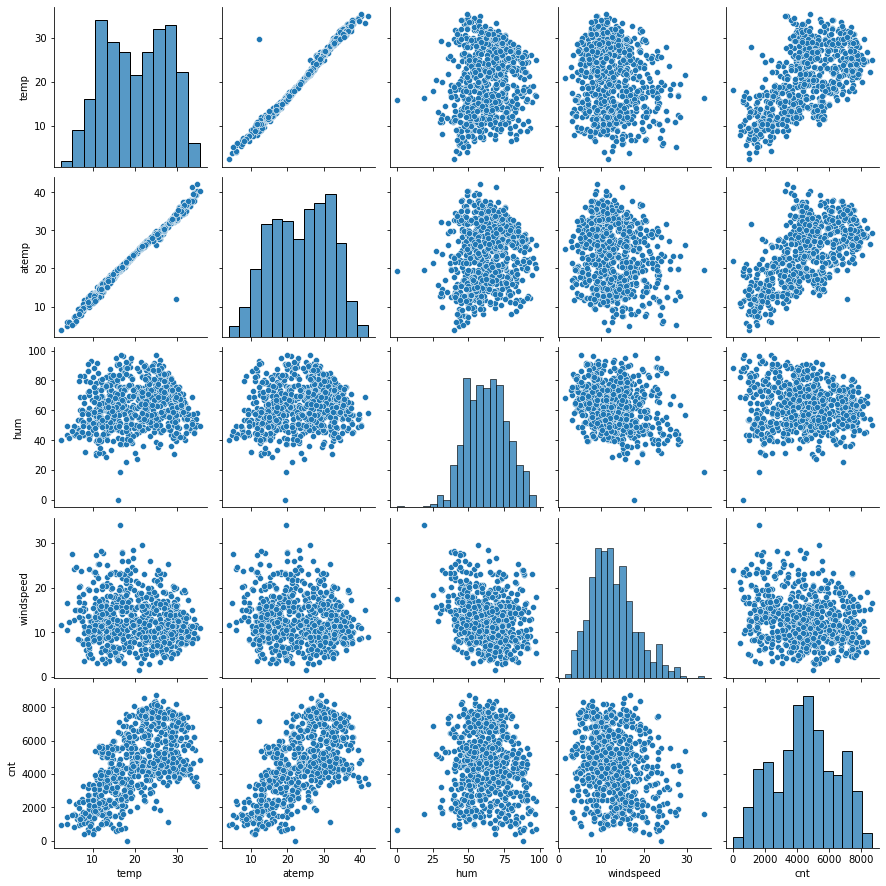

In [16]:
#visualize the numerical data - EDA
sns.pairplot(dayRecord[num_cols])
plt.show()

In [ ]:
# temp, atemp -positive linear relationship
# casual, registered - highly correlated 
#hum , windspeed - negative linear relationship

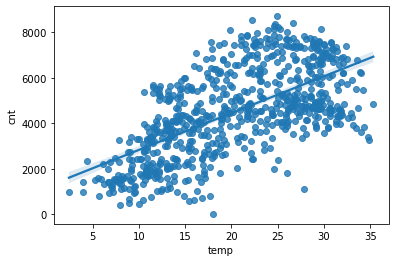

In [20]:
sns.regplot(x="temp",y='cnt',data=dayRecord)
plt.show()

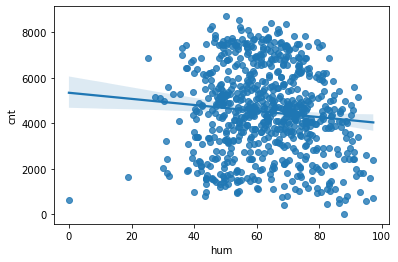

In [18]:
sns.regplot(x="hum",y='cnt',data=dayRecord)
plt.show()

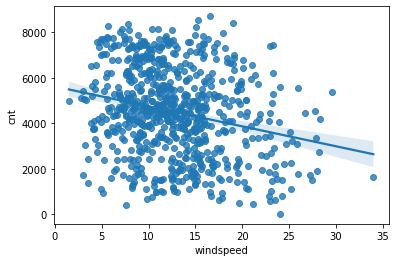

In [19]:
sns.regplot(x="windspeed",y='cnt',data=dayRecord)
plt.show()

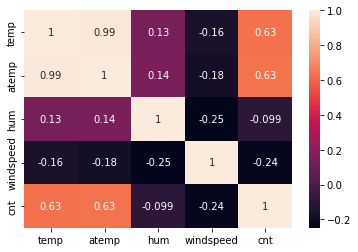

In [21]:
sns.heatmap(dayRecord[num_cols].corr(),annot=True)
plt.show()

In [13]:
cat_cols

['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

### Bi-variate (Categorical vs continous )

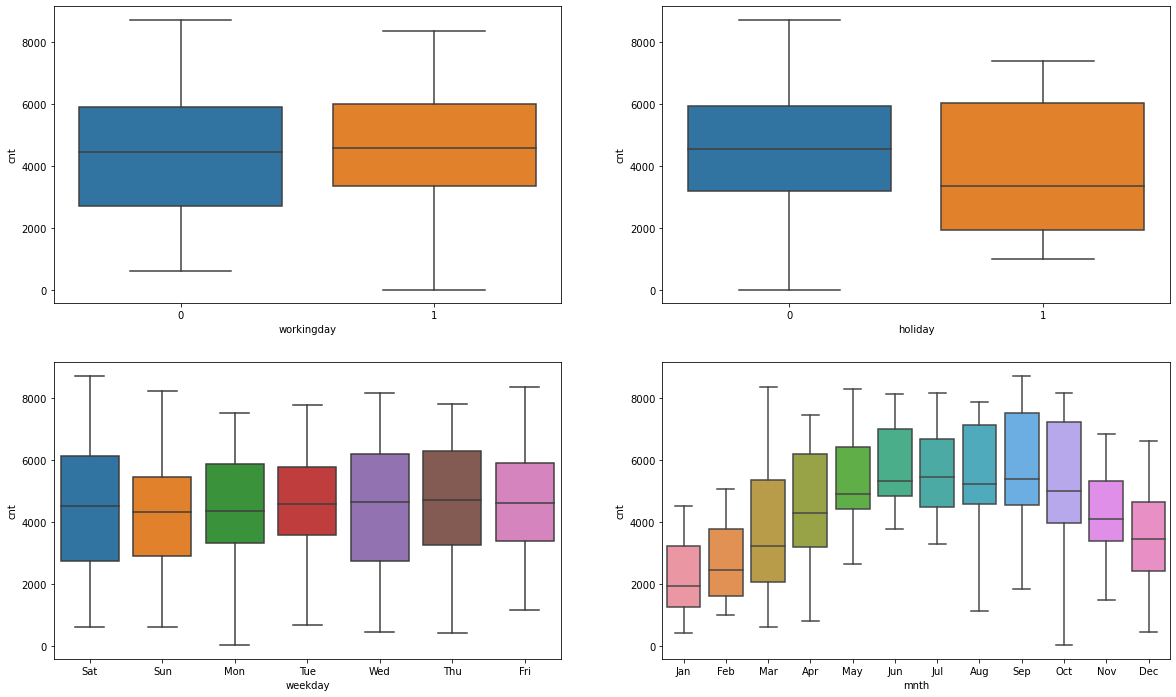

In [26]:
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
sns.boxplot(x="workingday",y="cnt",data=dayRecord)

plt.subplot(2,2,2)
sns.boxplot(x="holiday",y="cnt",data=dayRecord)

plt.subplot(2,2,3)
sns.boxplot(x="weekday",y="cnt",data=dayRecord)

plt.subplot(2,2,4)
sns.boxplot(x="mnth",y="cnt",data=dayRecord)

plt.show()


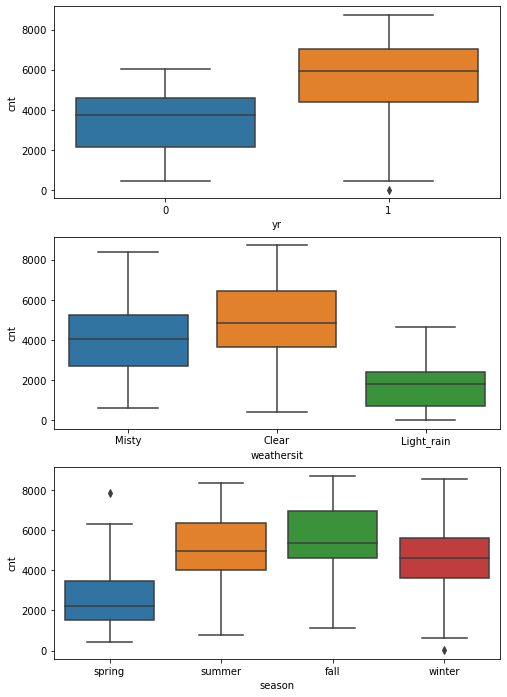

In [27]:
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
sns.boxplot(x="yr",y="cnt",data=dayRecord)

plt.subplot(3,1,2)
sns.boxplot(x="weathersit",y="cnt",data=dayRecord)

plt.subplot(3,1,3)
sns.boxplot(x="season",y="cnt",data=dayRecord)

plt.show()

## Encoding categorical variables with dummy values

In [7]:
seasons=pd.get_dummies(dayRecord["season"],drop_first=True)
dayRecord=pd.concat([dayRecord,seasons],axis=1)
dayRecord.drop("season",axis=1,inplace=True)
dayRecord.head()


,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,spring,summer,winter
0,0,Jan,0,Sat,0,Misty,14.110847,18.18125,80.5833,10.749882,985,1,0,0
1,0,Jan,0,Sun,0,Misty,14.902598,17.68695,69.6087,16.652113,801,1,0,0
2,0,Jan,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349,1,0,0
3,0,Jan,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562,1,0,0
4,0,Jan,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600,1,0,0


In [63]:
dayRecord.spring.value_counts

<bound method IndexOpsMixin.value_counts of 0      1
1      1
2      1
3      1
4      1
      ..
725    1
726    1
727    1
728    1
729    1
Name: spring, Length: 730, dtype: uint8>

In [8]:
weathers = pd.get_dummies(dayRecord.weathersit,drop_first=True)
dayRecord=pd.concat([dayRecord,weathers],axis=1)
dayRecord.drop("weathersit",axis=1,inplace=True)
dayRecord.head()

#clear 00
#light rain 10
#misty 01

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,Light_rain,Misty
0,0,Jan,0,Sat,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,1
1,0,Jan,0,Sun,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,1
2,0,Jan,0,Mon,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0
3,0,Jan,0,Tue,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0
4,0,Jan,0,Wed,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0


In [9]:
weekday = pd.get_dummies(dayRecord.weekday,drop_first=True)
dayRecord=pd.concat([dayRecord,weekday],axis=1)
dayRecord.drop("weekday",axis=1,inplace=True)
dayRecord.head()

,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,Light_rain,Misty,Mon,Sat,Sun,Thu,Tue,Wed
0,0,Jan,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,1,0,1,0,0,0,0
1,0,Jan,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,1,0,0,1,0,0,0
2,0,Jan,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0,1,0,0,0,0,0
3,0,Jan,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0,0,0,0,0,1,0
4,0,Jan,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0,0,0,0,0,0,1


In [10]:
months = pd.get_dummies(dayRecord.mnth,drop_first=True)
dayRecord=pd.concat([dayRecord,months],axis=1)
dayRecord.drop("mnth",axis=1,inplace=True)
dayRecord.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,1,0,0,0,0,0,0,0


### Split data into test and train 

In [11]:
np.random.seed(0)
df_train,df_test = train_test_split(dayRecord,train_size=0.7,random_state=100)

In [67]:
df_test.shape

(220, 30)

In [68]:
df_train.shape

(510, 30)

### Scaling all numeric-continous columns

In [12]:
scaler = MinMaxScaler()

In [13]:
scalingCols= ['temp','atemp','hum','windspeed','cnt']

In [71]:
dayRecord.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,1,0,0,0,0,0,0,0


In [14]:
#scaling the training set 
df_train[scalingCols]=scaler.fit_transform(df_train[scalingCols])

In [15]:
df_train[scalingCols].head()

,temp,atemp,hum,windspeed,cnt
576,0.815169,0.766351,0.725633,0.264686,0.827658
426,0.442393,0.438975,0.640189,0.255342,0.465255
728,0.245101,0.200348,0.498067,0.663106,0.204096
482,0.395666,0.391735,0.504508,0.188475,0.482973
111,0.345824,0.318819,0.751824,0.380981,0.191095


In [16]:
df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.513499,0.243137,0.247059,...,0.084314,0.066667,0.088235,0.076471,0.076471,0.098039,0.084314,0.086275,0.084314,0.080392
std,0.500429,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.224421,0.429398,0.431725,...,0.278131,0.249689,0.283915,0.266010,0.266010,0.297660,0.278131,0.281045,0.278131,0.272166
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# III- Model Building - OLS
- Training the model
- Residual analysis

### Training the model

Dividing into X and Y sets for the model building

In [17]:
y_train=df_train.pop('cnt')
X_train=df_train

#### Creating re-usable methods 

In [18]:
#method to calculate VIFs
def show_VIF(X_train_check):
    vif = pd.DataFrame()
    X = X_train_check
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [19]:
#method to build model with Statsmodel.api
def build_ols(y_input,X_input):
    X_const = sm.add_constant(X_input)

     # Running the linear model
    ols_model = sm.OLS(y_input,X_const).fit()  

    #the summary of our linear model
    print(ols_model.summary())
    
    #return the model 
    return ols_model
    

### Building Model 1 :

In [20]:
#Building model 1: with  variable - temp  - since its shows linear relationship with cnt

lm_temp=build_ols(y_train,X_train.temp)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     362.0
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           2.46e-61
Time:                        13:30:02   Log-Likelihood:                 176.09
No. Observations:                 510   AIC:                            -348.2
Df Residuals:                     508   BIC:                            -339.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1690      0.020      8.608      0.0

### Building Model 2 :

In [21]:
#Building model 2 by adding yr to the feature list 

X_temp_2 =X_train[['temp', 'yr']]
lm_temp_yr=build_ols(y_train,X_temp_2)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     568.2
Date:                Wed, 10 Apr 2024   Prob (F-statistic):          3.34e-130
Time:                        13:30:05   Log-Likelihood:                 338.80
No. Observations:                 510   AIC:                            -671.6
Df Residuals:                     507   BIC:                            -658.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0793      0.015      5.321      0.0

### Building Model with all variables :

In [22]:
#Building the model with all the variables
lm_all=build_ols(y_train,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     99.37
Date:                Wed, 10 Apr 2024   Prob (F-statistic):          2.81e-180
Time:                        13:30:26   Log-Likelihood:                 527.12
No. Observations:                 510   AIC:                            -996.2
Df Residuals:                     481   BIC:                            -873.4
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2433      0.035      6.887      0.0

In [23]:
show_VIF(X_train)

,Features,VIF
2,workingday,85.56
3,temp,66.90
4,atemp,56.03
13,Sat,19.71
14,Sun,18.34
7,spring,10.77
9,winter,9.46
8,summer,8.29
26,Nov,6.79
18,Aug,6.47


When training the model with all avialable variables , we can see many feautres have a high p-value making them isignificant . 
- Months like - Oct, June, March
- Days like - Wednesday,Thursday
- Features like Atemp and holiday

On calculating VIF, we see many variables having values higher than 5

### RFE To select features 

In [24]:
# we have 30 columns in total 
dayRecord.columns.size

30

In [25]:
# Running RFE with the output number of the variable equal to 20
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(estimator=lm,n_features_to_select=20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [26]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('Light_rain', True, 1),
 ('Misty', True, 1),
 ('Mon', False, 4),
 ('Sat', True, 1),
 ('Sun', False, 3),
 ('Thu', False, 6),
 ('Tue', False, 5),
 ('Wed', False, 7),
 ('Aug', False, 2),
 ('Dec', True, 1),
 ('Feb', True, 1),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', False, 9),
 ('Mar', False, 10),
 ('May', True, 1),
 ('Nov', True, 1),
 ('Oct', False, 8),
 ('Sep', True, 1)]

In [27]:
positivecol = X_train.columns[rfe.support_]
positivecol

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'spring', 'summer', 'winter', 'Light_rain', 'Misty', 'Sat', 'Dec',
       'Feb', 'Jan', 'Jul', 'May', 'Nov', 'Sep'],
      dtype='object')

In [28]:
negativecol = X_train.columns[~rfe.support_]
negativecol

Index(['Mon', 'Sun', 'Thu', 'Tue', 'Wed', 'Aug', 'Jun', 'Mar', 'Oct'], dtype='object')

### Building Model with variables selected by RFE 

In [29]:
#Building model 3 : using the columns selected by RFE

# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[positivecol]
rfe_model = build_ols(y_train,X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     140.3
Date:                Wed, 10 Apr 2024   Prob (F-statistic):          6.28e-188
Time:                        13:30:48   Log-Likelihood:                 525.41
No. Observations:                 510   AIC:                            -1009.
Df Residuals:                     489   BIC:                            -919.9
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2973      0.039      7.717      0.0

In [30]:
#check VIF for features selected by RFE
show_VIF(X_train_rfe)

,Features,VIF
3,temp,379.77
4,atemp,368.95
5,hum,31.79
7,spring,5.73
2,workingday,5.40
6,windspeed,5.13
9,winter,4.28
8,summer,3.59
15,Jan,2.40
11,Misty,2.33


### Building Model reccursively by removing insignificant  features : Model 4 to Model 11

In [31]:
#based on p-values and VIF, we can say atemp shows multicollinearity and is insignificant. 
# Building model 4 : removing atemp feature 
X_train_rfe.drop('atemp',axis=1,inplace=True)

In [32]:
lm_4 = build_ols(y_train,X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     148.0
Date:                Wed, 10 Apr 2024   Prob (F-statistic):          5.20e-189
Time:                        13:31:18   Log-Likelihood:                 525.39
No. Observations:                 510   AIC:                            -1011.
Df Residuals:                     490   BIC:                            -926.1
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2970      0.038      7.722      0.0

In [33]:
#check VIF for features 
show_VIF(X_train_rfe)

,Features,VIF
4,hum,31.74
3,temp,19.84
6,spring,5.62
2,workingday,5.40
5,windspeed,4.88
8,winter,4.12
7,summer,3.44
14,Jan,2.40
10,Misty,2.33
0,yr,2.11


In [113]:
#p-values are looking good for all variables
#VIF is high for temp, spring and workingday features. We start with removing workingday and see if it affects the rsults

In [34]:
# Building model 5 : dropping workingday feature 
X_train_rfe.drop('workingday',axis=1,inplace=True)

In [35]:
lm_5 = build_ols(y_train,X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     151.1
Date:                Wed, 10 Apr 2024   Prob (F-statistic):          5.95e-187
Time:                        13:31:26   Log-Likelihood:                 517.79
No. Observations:                 510   AIC:                            -997.6
Df Residuals:                     491   BIC:                            -917.1
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3371      0.038      8.977      0.0

In [36]:
#check VIF for features selected by RFE
show_VIF(X_train_rfe)

,Features,VIF
3,hum,31.56
2,temp,18.44
5,spring,5.47
4,windspeed,4.85
7,winter,4.08
6,summer,3.35
13,Jan,2.38
9,Misty,2.33
0,yr,2.11
12,Feb,1.92


In [37]:
#model 6 : remove 'spring'
X_train_rfe.drop('spring',axis=1,inplace=True)
lm_6 = build_ols(y_train,X_train_rfe)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     157.9
Date:                Wed, 10 Apr 2024   Prob (F-statistic):          1.05e-186
Time:                        13:31:37   Log-Likelihood:                 514.53
No. Observations:                 510   AIC:                            -993.1
Df Residuals:                     492   BIC:                            -916.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2867      0.032      8.980      0.0

In [38]:
show_VIF(X_train_rfe)

,Features,VIF
3,hum,25.11
2,temp,16.02
4,windspeed,4.07
6,winter,2.97
5,summer,2.62
8,Misty,2.23
0,yr,2.08
12,Jan,1.93
15,Nov,1.87
10,Dec,1.65


In [39]:
#model 7 : remove 'May'
X_train_rfe.drop('May',axis=1,inplace=True)
lm_7 = build_ols(y_train,X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     167.7
Date:                Wed, 10 Apr 2024   Prob (F-statistic):          1.33e-187
Time:                        13:31:57   Log-Likelihood:                 514.00
No. Observations:                 510   AIC:                            -994.0
Df Residuals:                     493   BIC:                            -922.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2815      0.032      8.934      0.0

In [40]:
show_VIF(X_train_rfe)

,Features,VIF
3,hum,25.06
2,temp,15.98
4,windspeed,4.00
6,winter,2.97
8,Misty,2.23
5,summer,2.13
0,yr,2.07
12,Jan,1.93
14,Nov,1.87
10,Dec,1.65


In [41]:
#model 8 : remove 'hum'
X_train_rfe.drop('hum',axis=1,inplace=True)
lm_8 = build_ols(y_train,X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     171.3
Date:                Wed, 10 Apr 2024   Prob (F-statistic):          1.20e-184
Time:                        13:32:01   Log-Likelihood:                 504.22
No. Observations:                 510   AIC:                            -976.4
Df Residuals:                     494   BIC:                            -908.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1970      0.025      7.757      0.0

In [42]:
show_VIF(X_train_rfe)

,Features,VIF
2,temp,5.24
3,windspeed,3.97
5,winter,2.57
0,yr,2.06
4,summer,1.95
13,Nov,1.82
7,Misty,1.56
12,Jul,1.53
9,Dec,1.42
14,Sep,1.32


In [43]:
#model 9 : remove 'Sat'
X_train_rfe.drop('Sat',axis=1,inplace=True)
lm_9 = build_ols(y_train,X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     182.6
Date:                Wed, 10 Apr 2024   Prob (F-statistic):          3.96e-185
Time:                        13:32:06   Log-Likelihood:                 502.66
No. Observations:                 510   AIC:                            -975.3
Df Residuals:                     495   BIC:                            -911.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2007      0.025      7.916      0.0

In [44]:
show_VIF(X_train_rfe)

,Features,VIF
2,temp,5.21
3,windspeed,3.92
5,winter,2.57
0,yr,2.06
4,summer,1.94
12,Nov,1.82
7,Misty,1.56
11,Jul,1.53
8,Dec,1.41
13,Sep,1.32


In [45]:
#model 10 : remove 'Nov'
X_train_rfe.drop('Nov',axis=1,inplace=True)
lm_10 = build_ols(y_train,X_train_rfe)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     195.2
Date:                Wed, 10 Apr 2024   Prob (F-statistic):          1.89e-185
Time:                        13:32:14   Log-Likelihood:                 500.68
No. Observations:                 510   AIC:                            -973.4
Df Residuals:                     496   BIC:                            -914.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1879      0.025      7.647      0.0

In [46]:
show_VIF(X_train_rfe)

,Features,VIF
2,temp,5.17
3,windspeed,3.84
0,yr,2.06
4,summer,1.94
5,winter,1.73
7,Misty,1.56
11,Jul,1.53
12,Sep,1.31
10,Jan,1.27
9,Feb,1.25


In [47]:
#model 11: remove dec,feb
X_train_rfe.drop(['Feb','Dec',"Jul"],axis=1,inplace=True)
lm_11 = build_ols(y_train,X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     248.0
Date:                Wed, 10 Apr 2024   Prob (F-statistic):          2.06e-186
Time:                        13:32:36   Log-Likelihood:                 494.49
No. Observations:                 510   AIC:                            -967.0
Df Residuals:                     499   BIC:                            -920.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1522      0.020      7.737      0.0

In [48]:
show_VIF(X_train_rfe)

,Features,VIF
2,temp,3.77
3,windspeed,3.31
0,yr,2.04
4,summer,1.62
7,Misty,1.53
5,winter,1.42
8,Jan,1.21
9,Sep,1.21
6,Light_rain,1.08
1,holiday,1.04


### Choosing model 11 as our final model :

In [49]:
X_train_lm = sm.add_constant(X_train_rfe)
lm_final = sm.OLS(y_train, X_train_lm).fit()
print(lm_final.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     248.0
Date:                Wed, 10 Apr 2024   Prob (F-statistic):          2.06e-186
Time:                        13:33:01   Log-Likelihood:                 494.49
No. Observations:                 510   AIC:                            -967.0
Df Residuals:                     499   BIC:                            -920.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1522      0.020      7.737      0.0

###  Predicting on train set using final model

In [50]:
y_train_pred = lm_final.predict(X_train_lm)

In [51]:
r2_score(y_train,y_train_pred)

0.8324770305005473

Text(0, 0.5, 'y_train_pred')

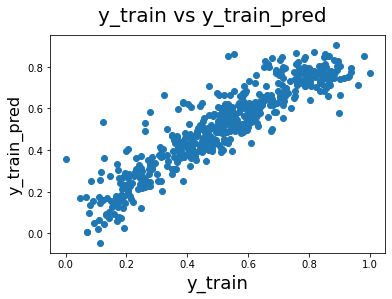

In [85]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_train,y_train_pred)
fig.suptitle('y_train vs y_train_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_train', fontsize=18)                          # X-label
plt.ylabel('y_train_pred', fontsize=16)  

## Residual analysis

### 1. Error terms are normally distributed

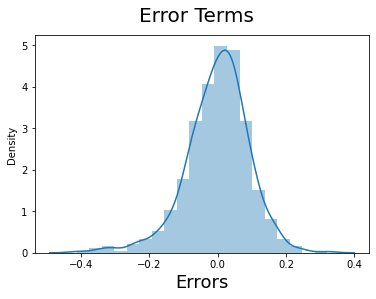

In [52]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)   
plt.show()

### 2 . Mean of residuals is 0 

In [75]:
residuals = y_train-y_train_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals -2.786986327992856e-16


### 3 .Homoscedasticity (variance of the residual terms in constant)

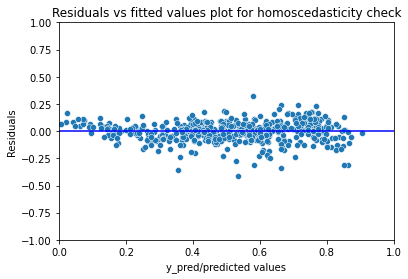

In [84]:
residuals = y_train-y_train_pred
p = sns.scatterplot(y_train_pred,residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-1,1)
plt.xlim(0,1)
p = sns.lineplot([0,1],[0,0],color='blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

In [54]:
#checking for multicollinearity
show_VIF(X_train_rfe)

,Features,VIF
2,temp,3.77
3,windspeed,3.31
0,yr,2.04
4,summer,1.62
7,Misty,1.53
5,winter,1.42
8,Jan,1.21
9,Sep,1.21
6,Light_rain,1.08
1,holiday,1.04


### Since we are able to validate the assumptions of linear regression using our final model, we can proceed with model evaluation and prediction on the test set

# IV -Model Evaluation
Prediction and evaluation on test set

In [57]:
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
184,0,1,0,29.793347,33.27085,63.7917,5.459106,6043,0,0,...,0,0,0,1,0,0,0,0,0,0
535,1,0,1,32.082500,36.04875,59.2083,7.625404,6211,0,1,...,0,0,0,0,1,0,0,0,0,0
299,0,0,1,19.270000,22.85230,81.2917,13.250121,2659,0,0,...,0,0,0,0,0,0,0,0,1,0
221,0,0,1,31.433347,34.24915,42.4167,13.417286,4780,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,1,29.315000,32.19710,30.5000,19.583229,4968,0,1,...,0,0,0,0,1,0,0,0,0,0


In [58]:
#Scaling the test set 
scalingCols= ['temp','atemp','hum','windspeed','cnt']

df_test[scalingCols]=scaler.transform(df_test[scalingCols])

In [59]:
df_test.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.036364,0.700000,0.558718,0.532847,0.638221,0.313293,0.522154,0.254545,0.263636,...,0.086364,0.100000,0.077273,0.104545,0.095455,0.054545,0.086364,0.072727,0.086364,0.086364
std,0.500809,0.187620,0.459303,0.233187,0.217401,0.148694,0.159584,0.219163,0.436599,0.441609,...,0.281541,0.300684,0.267633,0.306665,0.294512,0.227609,0.281541,0.260281,0.281541,0.281541
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,0.378595,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558172,0.544652,0.625590,0.300126,0.524678,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.755981,0.713308,0.743798,0.402718,0.677750,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [60]:
#split data into X and Y
y_test=df_test.pop('cnt')
X_test=df_test

In [61]:
X_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,spring,summer,winter,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0,0,0,...,0,0,0,1,0,0,0,0,0,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0,1,0,...,0,0,0,0,1,0,0,0,0,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0,0,1,...,0,0,0,0,0,0,0,0,1,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [62]:
X_train_rfe.columns

Index(['yr', 'holiday', 'temp', 'windspeed', 'summer', 'winter', 'Light_rain',
       'Misty', 'Jan', 'Sep'],
      dtype='object')

In [63]:
X_test.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'spring', 'summer', 'winter', 'Light_rain', 'Misty', 'Mon', 'Sat',
       'Sun', 'Thu', 'Tue', 'Wed', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun',
       'Mar', 'May', 'Nov', 'Oct', 'Sep'],
      dtype='object')

In [64]:
#Drop columns that are irrelavent from the test set 
X_test.drop(['workingday','atemp','hum', 'spring','Mon', 'Sat',
       'Sun', 'Thu', 'Tue', 'Wed', 'Aug', 'Dec', 'Feb','Jul', 'Jun',
       'Mar', 'May', 'Nov', 'Oct'],axis=1,inplace=True)

In [65]:
# Add the constant term to X_test set 
X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

,const,yr,holiday,temp,windspeed,summer,winter,Light_rain,Misty,Jan,Sep
184,1.0,0,1,0.831783,0.084219,0,0,0,1,0,0
535,1.0,1,0,0.901354,0.153728,1,0,0,0,0,0
299,1.0,0,0,0.511964,0.334206,0,1,0,1,0,0
221,1.0,0,0,0.881625,0.339570,0,0,0,0,0,0
152,1.0,0,0,0.817246,0.537414,1,0,0,0,0,0


## Predicting on Test Set

In [67]:
###Predict on test set 
y_test_pred=lm_final.predict(X_test_sm)

Text(0, 0.5, 'y_pred')

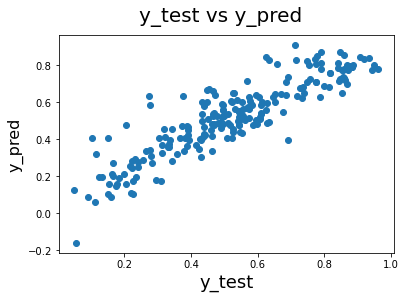

In [68]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)    

In [71]:
show_VIF(X_test)

,Features,VIF
2,temp,4.17
3,windspeed,4.02
0,yr,1.83
4,summer,1.68
7,Misty,1.43
5,winter,1.39
8,Jan,1.29
9,Sep,1.21
6,Light_rain,1.12
1,holiday,1.05


## R-score for the test set 

In [69]:
from sklearn.metrics import r2_score
r2_score(y_test, y_test_pred)

0.7920075467344522

## Conclusions : 

- Temp, windspeed, holiday, yr are some of the top features that govern the demand for rental bikes 
- R-score for train set -> 0.83 or 83% 
- R-score for test set -> 0.79 or 79% 

- Therefore,we can say that our model has done a good job at predicting demand for bikes 